<b>Declaration</b>

1. This is a project made by <b>@Author 22435044 XI RAO</b>
2. All the ".pt" file is our trained model, which helps to conduct comparative experiments 
3. All the classes for 3 tasks are encapsulated into the "Models.py".
4. "helper.py" encapsulates some of the common-use functions

In [12]:
import pandas as pd
import numpy as np
import collections
import re

In [13]:
import collections
import re

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

UsageError: Line magic function `%` not found.


In [15]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [16]:
import gensim
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

In [17]:
from argparse import Namespace

## Data Exploration

In [18]:
df=pd.read_csv('us_data_2000.csv')

### Data preparation for task 1

Task 1: transfer 'DEGREE_INJURY' to two classes of 'low_injury' and 'high_injury' for binary classification. The data have label of 'no value foun' were removed because we cannot know which classes they are.

1. **low_injury**: The low injury class refers to injuries that are not serious. The names and ID of the injury in this class are shown below, which has total 861 numbers in all dataset and 680 numbers in training data. 
<br>NO DYS AWY FRM WRK,NO RSTR ACT(6) ; INJURIES INVOLVNG NONEMPLOYEES(9); ACCIDENT ONLY(0); OCCUPATNAL ILLNESS NOT DEG 1-6(7); ALL OTHER CASES (INCL 1ST AID)(10); INJURIES DUE TO NATURAL CAUSES(8)



2. **high_injury**: The high injury class refers to injuries that are serious. The names and ID of the injury in this class are shown below, which has total 1128 numbers in all dataset and 991 numbers in training data.
<br>DAYS AWAY FROM WORK ONLY(3); DYS AWY FRM WRK & RESTRCTD ACT(4); PERM TOT OR PERM PRTL DISABLTY(2); FATALITY(1); 
DAYS RESTRICTED ACTIVITY ONLY(5)

In [19]:
# keep only relevant fiels for task 1
df_task1 = df[["DEGREE_INJURY", "DEGREE_INJURY_CD", 'NARRATIVE']]

In [20]:
# remove 'no_value_found' freature in 'DEGREE_INJURY'
df_task1 = df_task1[df_task1['DEGREE_INJURY_CD'] != '?']

In [21]:
df_task1.shape

(1989, 3)

In [22]:
# Task 1: transfer 'DEGREE_INJURY' to Binary labels
x = df_task1[['DEGREE_INJURY_CD']].replace(['3', '4', '2', '1', '5'], 'high_injury')
df_task1['binary_injury'] = x.replace(['6','9','0','7','10','8'], 'low_injury')

In [23]:
df_task1.head()

,DEGREE_INJURY,DEGREE_INJURY_CD,NARRATIVE,binary_injury
0,DAYS RESTRICTED ACTIVITY ONLY,5,Employee was cleaning up at the Primary Crushe...,high_injury
1,"NO DYS AWY FRM WRK,NO RSTR ACT",6,Handle of sledgehammer broke and head of hamme...,low_injury
2,DAYS AWAY FROM WORK ONLY,3,EMPLOYEE WAS CLIMBING DOWN A LADDER AND WHEN H...,high_injury
3,DAYS RESTRICTED ACTIVITY ONLY,5,HE PULLED A BACK MUSCLE WHILE STACKING BAGS OF...,high_injury
4,DAYS RESTRICTED ACTIVITY ONLY,5,EE hands began to break out in a rash after he...,high_injury


In [24]:
df_task1["binary_injury"].value_counts()

high_injury    1128
low_injury      861
Name: binary_injury, dtype: int64

In [25]:
# Split the data by 80/20
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_task1, test_size = 0.2, random_state = 0)

In [26]:
test.shape

(398, 4)

In [27]:
train["binary_injury"].value_counts()

high_injury    911
low_injury     680
Name: binary_injury, dtype: int64

In [28]:
train

,DEGREE_INJURY,DEGREE_INJURY_CD,NARRATIVE,binary_injury
160,DAYS AWAY FROM WORK ONLY,3,EE WAS REBUILDING HAUL ROAD BERM WITH LOADER W...,high_injury
1601,DAYS RESTRICTED ACTIVITY ONLY,5,Employee was re-positioning a jack leg drill d...,high_injury
320,ALL OTHER CASES (INCL 1ST AID),10,Employee has a pre-existing heart condition. ...,low_injury
998,DAYS AWAY FROM WORK ONLY,3,PIECE OF DRAWROCK FELL FROM BETWEEN BOLTS STRI...,high_injury
469,DAYS RESTRICTED ACTIVITY ONLY,5,Employee stated he experienced back discomfort...,high_injury
...,...,...,...,...
840,DAYS RESTRICTED ACTIVITY ONLY,5,Supervisor was walking from the map case back ...,high_injury
1223,DAYS AWAY FROM WORK ONLY,3,Employee was cleaning coal with a small loader...,high_injury
1661,DAYS AWAY FROM WORK ONLY,3,"Operator was tramming bolter and fell down, pu...",high_injury
563,"NO DYS AWY FRM WRK,NO RSTR ACT",6,Thumb smashed while trying to punch holes in b...,low_injury


In [29]:
# create new dataset for train binary classification
train_df = [train["binary_injury"],train["NARRATIVE"]]
headers = ["binary_injury", "NARRATIVE"]
Binary_df = pd.concat(train_df, axis=1, keys=headers)

# create new dataset for test binary classification
test_df = [test["binary_injury"],test["NARRATIVE"]]
headers = ["binary_injury", "NARRATIVE"]
test_injury = pd.concat(test_df, axis=1, keys=headers)

In [30]:
test_injury[['binary_injury']].describe()
# Unique classes
set(test_injury.binary_injury)

{'high_injury', 'low_injury'}

In [31]:
#Splitting the training dataset
by_injury = collections.defaultdict(list)
for _, row in Binary_df.iterrows():
    by_injury[row.binary_injury].append(row.to_dict())

In [32]:
# Create split data by 0.7 for training and 0.3 validation
final_list = []
np.random.seed(1337)

for _, item_list in sorted(by_injury.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = round(0.7 * n_total)  #--->638; 476
    n_val = round(0.3 * n_total)    #---->273; 204
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'

    # Add to final list
    final_list.extend(item_list)

In [33]:
# add text data
for _, row in test_injury.iterrows():
    row_dict = row.to_dict()
    row_dict['split'] = 'test'
    final_list.append(row_dict)

In [34]:
# the final dataset with train, test and validation data
final1 = pd.DataFrame(final_list)
final1.split.value_counts()

train    1114
val       477
test      398
Name: split, dtype: int64

### Data preparation for task 2

Task 2: Divide 'INJ_BODY_PART' to three classes by diffrent injury part of body, which are head&toe, extremities and trunk&mutipart. The data have label of 'NO VALUE FOUND' and 'UNCLASSIFIED' were removed because we cannot know which classes they are.

1. **head&toe**: The names and ID of the injury head&toe are shown below, which has total 597 numbers in all dataset and 481 numbers in training data.
EYE(S) OPTIC NERVE/VISON（130); HEAD,NEC(100); MOUTH/LIP/TEETH/TONGUE/THROAT/TASTE(142); EAR(S) INTERNAL &
HEARING(122); FACE,NEC(140）; JAW INCLUDE CHIN(311）; NOSE/NASAL PASSAGES/SINUS/SMELL(550）; BRAIN(110）; EAR(S) EXTERNAL(514）; SCALP(170）; FACE, MULTIPLE PARTS(314）; EAR(S) INTERNAL & EXTERNAL(120）; HEAD, MULTIPLE PARTS(144）; SKULL(160）; NECK(200）; TOE(S)/PHALANGES(540）; FINGER(S)/THUMB(340）   


2. **extremities**: The names and ID of the injury extremities are shown below, which has total 593 numbers in all dataset and 470 numbers in training data.
KNEE/PATELLA(512）; ANKLE(520）; HAND (NOT WRIST OR FINGERS)(330）; WRIST(320）; FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS(530）; ARM,NEC(310）; LOWER LEG/TIBIA/FIBULA(513）; FOREARM/ULNAR/RADIUS(313）; ELBOW(312）; LEG, NEC(510）; THIGH/FEMUR(511）; UPPER ARM/HUMERUS(141）; ARM, MULTIPLE PARTS(150）; LEG, MULTIPLE; PARTS(121）; LOWER EXTREMITIES, MULTIPLE PARTS(143）; UPPER EXTREMITIES, MULTIPLE(350）

3. **trunk&mutipart**: The names and ID of the injury extremities are shown below, which has total 566 numbers in all dataset and 453 numbers in training data.
ABDOMEN/INTERNAL ORGANS(410）; CHEST (RIBS/BREAST BONE/CHEST ORGNS)(430）; BACK (MUSCLES/SPINE/S-CORD/TAILBONE)(420）; SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA)(450）; HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)(440）; TRUNK,NEC(400）; BODY SYSTEMS(600）; BODY PARTS, NEC(800); TRUNK, MULTIPLE PARTS(460）; MULTIPLE PARTS (MORE THAN ONE MAJOR)(700）


In [35]:
df_task2 = df[['INJ_BODY_PART', 'INJ_BODY_PART_CD', 'NARRATIVE']]

In [36]:
# remove 'no_value_found'&'UNCLASSIFIED' freature in 'INJ_BODY_PART_CD'
df_task2 = df_task2[(df_task2['INJ_BODY_PART_CD'] != '?') & (df_task2['INJ_BODY_PART_CD']!='900')]

In [37]:
df_task2.shape

(1756, 3)

In [38]:
# Task 1: transfer 'INJ_BODY_PART' to mutiple classes
y = df_task2[['INJ_BODY_PART_CD']].replace(['410', '430', '420', '450', '440', '400', '600', '800','460','700'], 'trunk&mutipart')
y = y.replace(['512', '520', '330', '320', '530', '310', '513', '313', '312','510','511', '141', '150', '121','143','350'], 'extremities')
y = y.replace(['130', '100', '142', '122', '140', '311', '550', '110', '514', '170','314','120','144','160', '200','540','340'], 'head&toe')

df_task2['body_injury'] = y

In [39]:
df_task2["body_injury"].value_counts()

head&toe          597
extremities       593
trunk&mutipart    566
Name: body_injury, dtype: int64

In [40]:
# Split the data by 80/20
from sklearn.model_selection import train_test_split
train2, test2 = train_test_split(df_task2, test_size = 0.2, random_state = 0)

In [41]:
#test2.shape    #352
train2.shape       # 1404

(1404, 4)

In [42]:
train2["body_injury"].value_counts()

extremities       481
head&toe          470
trunk&mutipart    453
Name: body_injury, dtype: int64

In [43]:
# create new dataset for train mutiple classification
train2_df = [train2["body_injury"],train2["NARRATIVE"]]
headers = ["body_injury", "NARRATIVE"]
Mutiple_df = pd.concat(train2_df, axis=1, keys=headers)

# create new dataset for test mutiple classification
test2_df = [test2["body_injury"],test2["NARRATIVE"]]
headers = ["body_injury", "NARRATIVE"]
test_df = pd.concat(test2_df, axis=1, keys=headers)

In [44]:
test_df[['body_injury']].describe()
# Unique classes
set(test_df.body_injury)

{'extremities', 'head&toe', 'trunk&mutipart'}

In [45]:
#Splitting the training dataset
by_body_injury = collections.defaultdict(list)
for _, row in Mutiple_df.iterrows():
    by_body_injury[row.body_injury].append(row.to_dict())

In [46]:
# Create split data by 0.7 for training and 0.3 validation
final_list2 = []
np.random.seed(1337)

for _, item_list in sorted(by_body_injury.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = round(0.7 * n_total)  #--->638; 476
    n_val = round(0.3 * n_total)    #---->273; 204
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'

    # Add to final list
    final_list2.extend(item_list)

In [47]:
# add test data
for _, row in test_df.iterrows():
    row_dict = row.to_dict()
    row_dict['split'] = 'test'
    final_list2.append(row_dict)

In [48]:
# the final dataset with train, test and validation data
final2 = pd.DataFrame(final_list2)
final2.split.value_counts()

train    983
val      421
test     352
Name: split, dtype: int64

In [49]:
final2

,body_injury,NARRATIVE,split
0,extremities,sand covered rock that employee stepped on,train
1,extremities,PIECE OF ROCK FELL ON LEG WHILE SPLITTING ROCK...,train
2,extremities,"Employee stepped off bolter, placed foot on un...",train
3,extremities,EE WAS USING A RATCHET TO TIGHTEN A BOLT AND R...,train
4,extremities,"While tightening conveyor chain on buggy, ee p...",train
...,...,...,...
1751,extremities,"Employee was starting a 2"" gasoline powered wa...",test
1752,extremities,"While moving a miner out of a crosscut, he ste...",test
1753,trunk&mutipart,EMPLOYEE WAS OPERATING DOUBLE HEAD FLETCHER ON...,test
1754,extremities,THE EE WAS IN THE PROCESS OF ASSEMBLING A CHUT...,test


### Visualise to show the class balance

In [50]:
# Visualise to show the class balance for Task1 
train_data = final1[final1["split"] == 'train']

In [51]:
train_data.binary_injury.value_counts()

high_injury    638
low_injury     476
Name: binary_injury, dtype: int64

Text(0.5, 1.02, 'Task1 Class Balance')

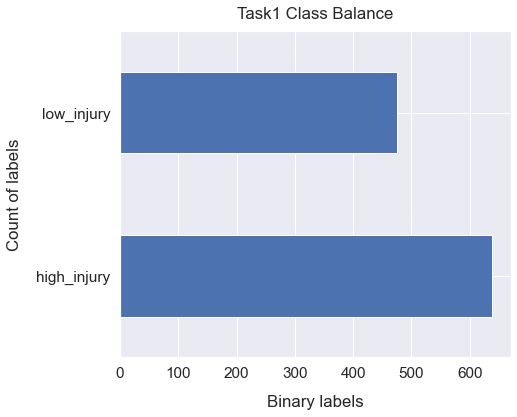

In [52]:
#train_data.binary_injury.value_counts().plot(kind = 'barh')

sns.set(font_scale=1.4)

train_data['binary_injury'].value_counts().plot(kind='barh', figsize=(7, 6), rot=0)
plt.xlabel("Binary labels", labelpad=14)
plt.ylabel("Count of labels", labelpad=14)
plt.title("Task1 Class Balance", y=1.02)

In [53]:
train_data2 = final2[final2["split"] == 'train']

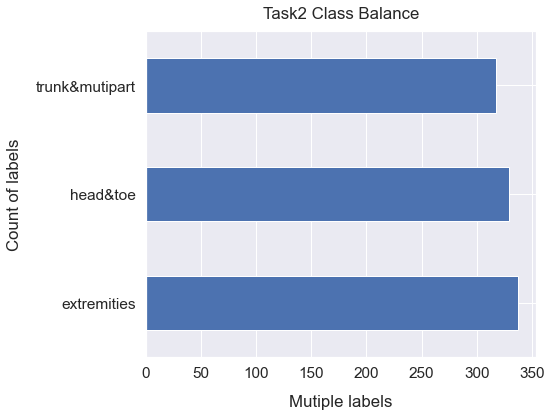

In [54]:
sns.set(font_scale=1.4)
train_data2['body_injury'].value_counts().plot(kind='barh', figsize=(7, 6), rot=0)
plt.xlabel("Mutiple labels", labelpad=14)
plt.ylabel("Count of labels", labelpad=14)
plt.title("Task2 Class Balance", y=1.02);

Text(0.5, 1.02, 'Task1 Class Balance')

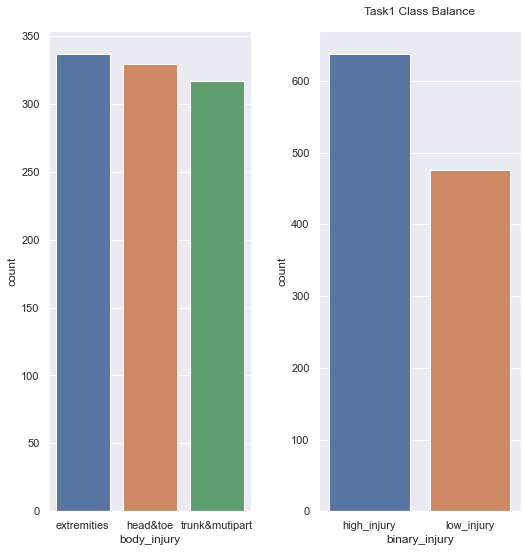

In [73]:
fig, ax =plt.subplots(1, 2, figsize = (8,8))
fig.tight_layout(pad=3.0)
sns.set_theme(style="darkgrid")
sns.countplot(x="body_injury", data=train_data2, ax=ax[0])
plt.title("Task2 Class Balance", y=1.02)

sns.countplot(x="binary_injury", data=train_data, ax=ax[1])
plt.title("Task1 Class Balance", y=1.02)

## Data Preprocessing and Preparation

In [97]:
# Preprocess the narrative to lowercase
def preprocess_text(text):
    if type(text) == float:
        print(text)
    text = text.lower()
    return text
    
final1.NARRATIVE = final1.NARRATIVE.apply(preprocess_text)

In [54]:
final2.NARRATIVE = final2.NARRATIVE.apply(preprocess_text)

In [98]:
len(final1.NARRATIVE.values)

1989

In [56]:
len(final2.NARRATIVE.values)

1756

In [99]:
final1.head()

,binary_injury,NARRATIVE,split
0,high_injury,"while bolting with a jackleg, a rock fell from...",train
1,high_injury,the employee was assisting a bolter operator b...,train
2,high_injury,during lubrication of wire being installed in ...,train
3,high_injury,employee was working on loader. he accidentall...,train
4,high_injury,employee was scraping cement from forms outdoo...,train


In [58]:
final2.head()

,body_injury,NARRATIVE,split
0,extremities,sand covered rock that employee stepped on,train
1,extremities,piece of rock fell on leg while splitting rock...,train
2,extremities,"employee stepped off bolter, placed foot on un...",train
3,extremities,ee was using a ratchet to tighten a bolt and r...,train
4,extremities,"while tightening conveyor chain on buggy, ee p...",train


### Tokenize and Lemmatize

In [100]:
#Tokenizeing the narrative in task1 and task2
narrative1 = list(final1.NARRATIVE.values)
narrative2 = list(final2.NARRATIVE.values)

In [101]:
doc_narrative1=nlp(str(narrative1))
doc_narrative2=nlp(str(narrative2))

In [102]:
# extract token of narrative in task1
narrative_words = []
narrative_lemma_words_lower=[]    
for token in doc_narrative1:
    if not token.is_punct:
        narrative_words.append(token)
        narrative_lemma_words_lower.append(token.lemma_)

In [103]:
len(list(set(narrative_lemma_words_lower)))

4551

### Stemming 

In [52]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [53]:
# using stemming for narrative in task1

tokenizer = nltk.RegexpTokenizer(r"\w+")
ps = PorterStemmer()

narrative_words_stem = []
narrative_stem_words_lower=[]

for sen in narrative1:
    new_words = tokenizer.tokenize(sen)                              
    for word in new_words:
        narrative_words_stem.append(word)
        narrative_stem_words_lower.append(ps.stem(word))

In [54]:
len(set(narrative_stem_words_lower))

3791

In [69]:
# the diffrent words bewteen stem and lemma
len(set(narrative_stem_words_lower) - set(narrative_lemma_words_lower))

1212

In [70]:
# the diffrent between lemma and stem 
len(set(narrative_lemma_words_lower) - set(narrative_stem_words_lower))

1972

In [61]:
#The same word in lemma and stem
len(set(narrative_lemma_words_lower) & set(narrative_stem_words_lower))

2579

Comparing with lemmatize and stemming, stemming has a stronger ability of transfering words to its basic root form. some words transfered by stemming are not be the dictionary words, which is difficult for people to understand. So in the follwing tasks, we use lemmatize to restoration the words. 

### Using lemma words to create the dataset for task1 and task2

In [104]:
# create the dataset for task1 with lemma words
list_column=[]

for sent in narrative1:
    words_token = nlp(str(sent))
    strword = ''
    for token in words_token:
        if not token.is_punct:
            if not token.is_stop:
                strword += ' ' + token.lemma_
                list(strword)
    list_column.append(strword)

In [75]:
# create the dataset for task2 with lemma words
list_column1=[]

for sent in narrative2:
    words_token = nlp(str(sent))
    strword = ''
    for token in words_token:
        if not token.is_punct:
            if not token.is_stop:
                strword += ' ' + token.lemma_
                list(strword)
    list_column1.append(strword)

In [105]:
final1.NARRATIVE = list_column

In [106]:
final1.head()

,binary_injury,NARRATIVE,split
0,high_injury,bolt jackleg rock fall rib,train
1,high_injury,employee assist bolter operator make bolt pos...,train
2,high_injury,lubrication wire instal electrical conduit em...,train
3,high_injury,employee work loader accidentally step home l...,train
4,high_injury,employee scrape cement form outdoors snow for...,train


In [78]:
final2.NARRATIVE = list_column1

In [79]:
final2.head()

,body_injury,NARRATIVE,split
0,extremities,sand cover rock employee step,train
1,extremities,piece rock fall leg splitting rock put rock p...,train
2,extremities,employee step bolter place foot uneven ground...,train
3,extremities,ee ratchet tighten bolt ratchet slip cause st...,train
4,extremities,tighten conveyor chain buggy ee right foot ra...,train


### Remove stop words (rank words according to TF/IDF).

In [107]:
def sent_to_words(corpus):
    for conversation in corpus:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(conversation), deacc=True)) 

In [108]:
# remove functuations and tranfer sentence to words 
doc_tokenized = list(sent_to_words(list(final1.NARRATIVE.values)))

In [84]:
doc_tokenized1 = list(sent_to_words(list(final2.NARRATIVE.values)))

In [109]:
# transfer words in each doc to bag of words
dictionary = Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

In [86]:
# transfer words in each doc to bag of words
dictionary1 = Dictionary()
BoW_corpus1 = [dictionary1.doc2bow(doc, allow_update=True) for doc in doc_tokenized1]

In [62]:
for doc in BoW_corpus[:5]:
    print([[dictionary[id], freq] for id, freq in doc])
    print("\n")

[['bolt', 1], ['fall', 1], ['jackleg', 1], ['rib', 1], ['rock', 1]]


[['bolt', 2], ['rock', 1], ['ankle', 1], ['assist', 1], ['bolter', 1], ['cause', 1], ['damage', 1], ['employee', 3], ['extended', 1], ['fracture', 1], ['hand', 1], ['hyper', 1], ['knee', 2], ['leg', 1], ['ligament', 1], ['low', 1], ['make', 1], ['operator', 2], ['plus', 1], ['position', 1], ['possible', 1], ['strike', 1], ['sustain', 1]]


[['cause', 2], ['employee', 1], ['hand', 2], ['box', 3], ['conduit', 1], ['edge', 1], ['electrical', 2], ['glove', 1], ['grab', 1], ['guard', 1], ['improper', 1], ['instal', 1], ['laceration', 1], ['left', 1], ['lubrication', 1], ['pull', 1], ['reach', 1], ['repair', 1], ['require', 1], ['result', 1], ['root', 1], ['slip', 1], ['slippery', 1], ['stand', 1], ['stitch', 1], ['surface', 1], ['surgical', 1], ['tendon', 1], ['use', 1], ['wear', 1], ['wet', 1], ['wire', 2]]


[['fall', 1], ['ankle', 1], ['cause', 1], ['employee', 1], ['knee', 1], ['accidentally', 1], ['floor', 1], ['home

In [110]:
# calculate tfidf
import numpy as np
tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
 
for doc in tfidf[BoW_corpus[:5]]:
    print([[dictionary[id], np.around(freq,decimals=2)] for id, freq in doc])
    print("\n")

[['bolt', 0.31], ['fall', 0.19], ['jackleg', 0.71], ['rib', 0.51], ['rock', 0.31]]


[['bolt', 0.22], ['rock', 0.11], ['ankle', 0.15], ['assist', 0.22], ['bolter', 0.19], ['cause', 0.08], ['damage', 0.19], ['employee', 0.12], ['extended', 0.32], ['fracture', 0.15], ['hand', 0.09], ['hyper', 0.3], ['knee', 0.24], ['leg', 0.14], ['ligament', 0.29], ['low', 0.13], ['make', 0.22], ['operator', 0.3], ['plus', 0.32], ['position', 0.19], ['possible', 0.23], ['strike', 0.1], ['sustain', 0.19]]


[['cause', 0.12], ['employee', 0.03], ['hand', 0.13], ['box', 0.42], ['conduit', 0.21], ['edge', 0.14], ['electrical', 0.3], ['glove', 0.14], ['grab', 0.15], ['guard', 0.14], ['improper', 0.2], ['instal', 0.12], ['laceration', 0.1], ['left', 0.06], ['lubrication', 0.25], ['pull', 0.09], ['reach', 0.13], ['repair', 0.12], ['require', 0.1], ['result', 0.1], ['root', 0.22], ['slip', 0.06], ['slippery', 0.19], ['stand', 0.12], ['stitch', 0.1], ['surface', 0.15], ['surgical', 0.22], ['tendon', 0.2], ['use',

In [87]:
# calculate tfidf
import numpy as np
tfidf1 = TfidfModel(BoW_corpus1, smartirs='ntc')
 
for doc in tfidf1[BoW_corpus1[:5]]:
    print([[dictionary1[id], np.around(freq,decimals=2)] for id, freq in doc])
    print("\n")

[['cover', 0.57], ['employee', 0.1], ['rock', 0.3], ['sand', 0.69], ['step', 0.31]]


[['rock', 0.42], ['accident', 0.18], ['alecia', 0.35], ['clifford', 0.35], ['fall', 0.15], ['happen', 0.27], ['leg', 0.14], ['mb', 0.35], ['noi', 0.35], ['pallet', 0.21], ['piece', 0.11], ['put', 0.19], ['splitting', 0.32]]


[['employee', 0.05], ['step', 0.15], ['ankle', 0.2], ['bolter', 0.25], ['boot', 0.29], ['diagnose', 0.23], ['duty', 0.2], ['foot', 0.16], ['ground', 0.19], ['left', 0.1], ['light', 0.27], ['negative', 0.34], ['place', 0.18], ['release', 0.2], ['strain', 0.17], ['turn', 0.21], ['uneven', 0.34], ['walk', 0.17], ['xray', 0.38]]


[['bolt', 0.19], ['cause', 0.13], ['ee', 0.09], ['ratchet', 0.86], ['slip', 0.14], ['strike', 0.14], ['tighten', 0.31], ['wrist', 0.26]]


[['leg', 0.27], ['foot', 0.11], ['ground', 0.14], ['ee', 0.06], ['slip', 0.09], ['tighten', 0.19], ['break', 0.13], ['buggy', 0.31], ['chain', 0.17], ['conveyor', 0.16], ['jam', 0.23], ['jump', 0.22], ['plateau', 0.34], 

In [92]:
#extract stop word in task1 that tfidf <= 0.1
without_stopword=[]
stopword = []
for sentence in tfidf[BoW_corpus]:
    for word in sentence:
        if word[1]>0.1:
            without_stopword.append(word)
        else:
            stopword.append(word)

In [98]:
#extract stop word in task2 that tfidf <= 0.1 multi
without_stopword1=[]
stopword1 = []
for sentence in tfidf1[BoW_corpus1]:
    for word in sentence:
        if word[1]>0.1:
            without_stopword1.append(word)
        else:
            stopword1.append(word)

In [111]:
#remove stop word that tfidf <= 0.1 in task1
list_column = []

for sentence in tfidf[BoW_corpus]:
    strword = ''
    for word in sentence:
        #print(dictionary[word[0]])
        if word[1]>0.1:
            #print(word[1], '--->', dictionary[word[0]])
            strword += ' ' + dictionary[word[0]]
            list(strword)
    list_column.append(strword)
    
#list_column

In [99]:
#remove stop word that tfidf <= 0.1 in task2
list_column1 = []

for sentence in tfidf1[BoW_corpus1]:
    strword = ''
    for word in sentence:
        #print(dictionary[word[0]])
        if word[1]>0.1:
            #print(word[1], '--->', dictionary[word[0]])
            strword += ' ' + dictionary[word[0]]
            list(strword)
    list_column1.append(strword)
    
#list_column

In [112]:
final1.NARRATIVE = list_column

In [101]:
final2.NARRATIVE = list_column1

In [113]:
final1

,binary_injury,NARRATIVE,split
0,high_injury,bolt fall jackleg rib rock,train
1,high_injury,bolt rock ankle assist bolter damage employee...,train
2,high_injury,cause hand box conduit edge electrical glove ...,train
3,high_injury,fall ankle cause knee accidentally floor home...,train
4,high_injury,advise care cement complete course diagnose d...,train
...,...,...,...
1984,high_injury,process continue shaft run winch raising work...,test
1985,high_injury,employee left pull feel help pain shoulder ti...,test
1986,low_injury,feel remove small material eye site med build...,test
1987,high_injury,strike pull right forearm bar fly belt red devil,test


In [103]:
final2

,body_injury,NARRATIVE,split
0,extremities,bolt jackleg rib rock,train
1,extremities,jackleg ankle assist bolter cause damage empl...,train
2,extremities,rock ligament low make operator plus position...,train
3,extremities,instal laceration lubrication pull reach repa...,train
4,extremities,employee position possible repair result root...,train
...,...,...,...
1751,extremities,laceration tendon hang trip methane tire clea...,test
1752,extremities,rock course center lbsledge shoulder bracket ...,test
1753,trunk&mutipart,hyper knee instal complete miner reinstall su...,test
1754,extremities,employee hyper left reach curtain equipment m...,test


In [114]:
final1["binary_injury"].value_counts()

high_injury    1128
low_injury      861
Name: binary_injury, dtype: int64

In [104]:
final2["body_injury"].value_counts()

head&toe          597
extremities       593
trunk&mutipart    566
Name: body_injury, dtype: int64

In [115]:
final1[pd.isnull(final1.binary_injury)]

,binary_injury,NARRATIVE,split


In [106]:
final2[pd.isnull(final2.body_injury)]

,body_injury,NARRATIVE,split


In [121]:
#Save final1 to csv
final1.to_csv('final1.csv')

In [107]:
#Save final1 to csv
final2.to_csv('final2.csv')

These are the final used datasets for Task1 and Task2. The NARRATIVE in the dataset are prepareing by words lemmatization and removing stop words using spacy and TFIDF. The NARRATIVE will be transfered to vectorior type for the model use in the future. 

## Task 1: Binary Document Classification

### Feed-forward Neural Network model

The FFNN model use one hot encoding to convert NARRATIVE inputs to vectorized minibatches. The one hot encoding is calling by 'vectorize' function that is implemented inside the 'ReviewVectorizer' class shown in the attached file of 'models.py'. 

In [216]:
import torch
from Models import *
from helpers import *

In [217]:
#training 

from argparse import Namespace
args = Namespace(
    # Data and path information
    body_csv="/Users/yuanbo/Desktop/cits4012/final1.csv",
    frequency_cutoff=25,
    model_state_file='model.pth',
    save_dir='/Users/yuanbo/Desktop/cits4012',
    vectorizer_file='vectorizer.json',
    # No model hyperparameters
    # Training hyperparameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.03,
    num_epochs=100,
    seed=1337,
    # Runtime options
    cuda=True,
    reload_from_files=False,
    device='cuda',
)

In [218]:
import torch
import torch.optim as optim
import pandas as pd

def make_train_state(args):
    return {'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            }

train_state = make_train_state(args)

if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

#dataset and vectorizer
final1 = pd.read_csv(args.body_csv)
dataset = InjuryDataset.load_dataset_and_make_vectorizer(final1)
vectorizer = dataset.get_vectorizer()

# model
classifier = InjuryClassifier(num_features=len(vectorizer.NARRATIVE_vocab))
classifier = classifier.to(args.device)
# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

In [219]:
def compute_accuracy_binary(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [220]:
import numpy as np
for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()
    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:
        # step 1. zero the gradients
        optimizer.zero_grad()
        # step 2. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index + 1)
        # step 4. use loss to produce gradients
        loss.backward()
        # step 5. use optimizer to take gradient step
        optimizer.step()
        # compute the accuracy
        acc_batch = compute_accuracy_binary(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Iterate over val dataset
    # setup: batch generator, set loss and acc to 0, set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # step 1. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        # step 2. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        # step 3. compute the accuracy
        acc_batch = compute_accuracy_binary(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

We make the test code as a function so that we can compare the result at the end of this task

In [222]:
def test_ffn(model, args):
    classfier = torch.load(model)
    dataset.set_split('test')
    batch_generator = generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        # compute the accuracy
        acc_batch = compute_accuracy_binary(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)
    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    return train_state['test_loss'], train_state['test_acc']

In [225]:
torch.save(classifier, "FFN1.pt")

In [226]:
model = torch.load('FFN1.pt')
model.eval()

InjuryClassifier(
  (fc1): Linear(in_features=238, out_features=1, bias=True)
)

In [229]:
loss_ffn2, acc_ffn2 = test_ffn("FFN1.pt", args)

print("Test loss: {:.3f}".format(loss_ffn2))
print("Test Accuracy: {:.2f}".format(acc_ffn2))

Test loss: 0.678
Test Accuracy: 71.61


In [136]:
torch.save(classifier, "FFN.pt")

In [137]:
model = torch.load('FFN.pt')
model.eval()

InjuryClassifier(
  (fc1): Linear(in_features=238, out_features=1, bias=True)
)

In [224]:
loss_ffn1, acc_ffn1 = test_ffn("FFN.pt", args)
print("Test loss: {:.3f}".format(loss_ffn1))
print("Test Accuracy: {:.2f}".format(acc_ffn1))

Test loss: 0.682
Test Accuracy: 71.88


### A CNN Conv1d based model

The CNN model use 100 dimention Glove pre-trained word embedding to convert NARRATIVE to 100 dimention vectors. We load the pre-trained word embedding file and produce the word embedding matrix of NARRATIVE by calling 'make_embedding_matrix' function shown below. The produced word embedding are implmented in training CNN by calling the class 'NewsClassifier' shown in the attached 'Models.py' file.

In [240]:
args = Namespace(
    # Data and Path hyper parameters
    news_csv="/Users/yuanbo/Desktop/cits4012/final1.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="/Users/yuanbo/Desktop/cits4012",
    # Model hyper parameters
    glove_filepath='glove.6B.100d.txt', 
    use_glove=False,
    embedding_size=100, 
    hidden_dim=100, 
    num_channels=100, 
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.01, #0.009     #0.01
    dropout_p=0.2,     #0.2~0.3      #0.1
    batch_size=128, 
    num_epochs=150,   
    early_stopping_criteria=10, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	/Users/yuanbo/Desktop/cits4012/vectorizer.json
	/Users/yuanbo/Desktop/cits4012/model.pth
Using CUDA: False


In [241]:
# initialization
args.use_glove = True

In [242]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = NewsDataset.load_dataset_and_load_vectorizer(args.news_csv,
                                                           args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

classifier = NewsClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_channels=args.num_channels,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

Using pre-trained embeddings


In [168]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [169]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [170]:
# Training loop
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/150 [00:00<?, ?it/s]

split=train:   0%|          | 0/8 [00:00<?, ?it/s]

split=val:   0%|          | 0/3 [00:00<?, ?it/s]

In [243]:
def test(modelname, args):  
    
    # compute the loss & accuracy on the test set using the best available model

    #classifier.load_state_dict(torch.load(train_state['model_filename']))
    classifier = torch.load(modelname)
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_data'])

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    return train_state['test_loss'],  train_state['test_acc']

In [146]:
def save(name, model):
    torch.save(model, name)

In [162]:
loss, acc = test("CNN.pt")

In [163]:
print("Test loss: {};".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.5631030996640524;
Test Accuracy: 73.69791666666667


In [158]:
model = torch.load('CNN.pt')
model.eval()

NewsClassifier(
  (emb): Embedding(135, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [164]:
loss, acc = test("CNN.pt")

print("Test loss: {};".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.5549281636873881;
Test Accuracy: 73.4375


In [191]:
model = torch.load('CNN1.pt')
model.eval()

NewsClassifier(
  (emb): Embedding(135, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [199]:
loss1, acc1 = test("CNN1.pt", args)

print("Test loss: {};".format(loss1))
print("Test Accuracy: {}".format(acc1))

Test loss: 0.5390400489171346;
Test Accuracy: 74.73958333333333


#### We have made 3 models for this task so far
1. A feed-forward neural network model with one hot word embedding, learing rate (0.003)
2. A CNN model with glove 100d pre-trained word embedding, learing rate (0.001),  dropout (0.1)
3. A CNN model with glove 100d pre-trained word embedding, learing rate (0.001), dropout (0.2)

##### 1. Load FFN model

In [230]:
model = torch.load('FFN.pt')
model.eval()

InjuryClassifier(
  (fc1): Linear(in_features=238, out_features=1, bias=True)
)

In [231]:
loss_ffn1, acc_ffn1 = test_ffn("FFN.pt", args)
print("Test loss: {:.3f}".format(loss_ffn1))
print("Test Accuracy: {:.2f}".format(acc_ffn1))

Test loss: 0.681
Test Accuracy: 72.14


##### 2. Load CNN model with learning rate 0.001 and dropout 0.1 

In [246]:
model = torch.load('CNN.pt')
model.eval()

NewsClassifier(
  (emb): Embedding(135, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [247]:
loss1, acc1 = test("CNN.pt", args)

print("Test loss: {};".format(loss1))
print("Test Accuracy: {}".format(acc))

Test loss: 0.552660197019577;
Test Accuracy: 73.4375


##### 3. Load CNN model with learning rate 0.001 and dropout 0.2

In [244]:
model = torch.load('CNN1.pt')
model.eval()

NewsClassifier(
  (emb): Embedding(135, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 100, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [245]:
loss_cnn1, acc_cnn1 = test("CNN1.pt", args)

print("Test loss: {};".format(loss_cnn1))
print("Test Accuracy: {}".format(acc_cnn1))

Test loss: 0.5551626483599345;
Test Accuracy: 74.47916666666667


<b>Performance Analysis</b>

The highest test accuracy in FFN model is 72.1, which is slightly lower than both CNN models with accuracy 73.4 and 74.5 respectively. That means CNN may more powrful than FFN in binary classification nlp task. Moreover, we use the pre-trained word embedding in CNN classifier, which may help the classifier to catch up more text feature. As a whole, these 3 models provides pretty close accuracy on test dataset. One of important reason that CNN did not critically increase the perfomance is probably because we have trained the model on small dataset. CNN usually need to be trained on larger dataset to obtain better performance. Also, CNN with glove is a more complex model compared to FFN, which means there are more hypyer-parameters to adujust before the training. In addition, a slight increase of dropout ratio in CNN may increase the model performance. The drop ratio used in the training process to reduce time consuming and avoid overfitting. 

## Task 2: Multi-class Document Classification

#### RNN

In this task, we use the simple RNN to train the classifier. The class <b>MultiVectorizer</b> is used to encode the narrative data into vectors, <b>Injury2Dataset</b> is the dataloader. <b>Injury2Classifier</b> is the model we use for training the document classifier. These classes are packed into the Models.py.

In [1]:
from Models import *
from helpers import *

In [2]:
args = Namespace(
    # Data and path information
    body_csv= "C:/Users/George/CITS4012/final2.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="C:/Users/George/CITS4012",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=128,
    # Training hyper parameter
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=256,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: True


In [8]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = Injury2Dataset.load_dataset_and_load_vectorizer(args.body_csv, 
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = Injury2Dataset.load_dataset_and_make_vectorizer(args.body_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = Injury2Classifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.NARRATIVE),
                               num_classes=len(vectorizer.body_injury),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.NARRATIVE.mask_index)

In [9]:
print(classifier)

Injury2Classifier(
  (emb): Embedding(31, 100, padding_idx=0)
  (rnn): ElmanRNN(
    (rnn_cell): RNNCell(100, 128)
  )
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [10]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

In [5]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


In [13]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/3 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
torch.save(classifier, "RNN.pt")

In [10]:
def test(modelname, args):
    model = torch.load(modelname)
    model = model.to(args.device)
    train_state = make_train_state(args)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    model.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  model(batch_dict['x_data'],
                             x_lengths=batch_dict['x_length'])

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    
    return  train_state['test_loss'], train_state['test_acc']

In [12]:
model_rnn = torch.load("RNN.pt")
model_rnn.eval()

Injury2Classifier(
  (emb): Embedding(31, 100, padding_idx=0)
  (rnn): ElmanRNN(
    (rnn_cell): RNNCell(100, 128)
  )
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [13]:
loss, acc = test("RNN.pt", args)

print("Test loss: {};".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 1.10857355594635;
Test Accuracy: 34.765625


#### GRU

In this part, we use the bi-GRU to train the classifier instead of a simple RNN. As well known, rnn is a model with short-term memory. When dealing with the long sequence samples, rnn may forget the previous semantic features and become struggle to learn. Thus, using the bi-GRU model can help to memorise the further semantic feature of the sequence sample. Moreover, we apply the pre-trained word embedding to improve the model accuracy.

The class <b>MultiVectorizer</b> is used to encode the narrative data into vectors, <b>Injury2Dataset</b> is the dataloader. <b>InjuryGRUClassifier</b> is the model we use for training the document classifier. These classes are packed into the Models.py. Besides, we make the pre-trained word embedding matrix by a method called "make_embedding_matrix()" that is packed in the helper.py.

In [1]:
from Models import *
from helpers import *

In [14]:
args = Namespace(
    # Data and path information
    body_csv="C:/Users/George/CITS4012/final2.csv",
    vectorizer_file="vectorizer_LS_1.json",
    model_state_file="model_LS_1.pth",
    save_dir="C:/Users/George/CITS4012",
    glove_filepath="C:/Users/George/CITS4012/glove/glove.6B.100d.txt", 
    use_glove=False,
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=128,
    bidirection = True,
    n_layer = 1,
    # Training hyper parameter
    num_epochs=80,
    learning_rate=0.006,
    batch_size=128,
    seed=1337,
    early_stopping_criteria=10,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: True


In [3]:
#Use the word embedding
args.use_glove = True

In [19]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = Injury2Dataset.load_dataset_and_load_vectorizer(args.body_csv, 
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = Injury2Dataset.load_dataset_and_make_vectorizer(args.body_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

Set the argument "args.use_glove" is true means we want to use glove as pre-trained word embedding. Then, we load the glove file and make the embedding matrix by make_embedding_matrix(), this method is packed into the helpers.py.

In [4]:
# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.NARRATIVE._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [5]:
embeddings

array([[-0.20555636, -0.00213669,  0.06000623, ...,  0.05345052,
        -0.21676874,  0.12614274],
       [-0.23994221,  0.22909459, -0.13612111, ..., -0.01033159,
        -0.19344293, -0.16833046],
       [-0.23632628,  0.1060884 , -0.20055968, ...,  0.18710664,
        -0.03777884, -0.15639886],
       ...,
       [-0.69182   ,  0.47268   ,  0.41292   , ..., -0.29114   ,
         0.081476  , -1.4222    ],
       [-0.55668   ,  0.67273   ,  0.82171   , ..., -0.7515    ,
        -0.045485  , -0.12946   ],
       [-0.0049027 ,  0.21282   ,  0.27713   , ..., -0.72202   ,
        -0.22217   , -0.71125   ]])

The default RNN model is GRU, but we can change the argument "rnn_model" to LSTM if we want to train with LSTM. And we pass the pre-trained word embedding to our GRU classifier. If don't use the pre-trained word embedding, the argument "embedding_tensor" should be set to "None".

In [22]:
model = InjuryGRUClassifier(vocab_size=len(vectorizer.NARRATIVE),
                               embed_size=args.char_embedding_size,
                               num_output=len(vectorizer.body_injury),
                               rnn_model='GRU',
                               embedding_tensor= embeddings,
                               hidden_size=args.rnn_hidden_size,
                               num_layers=args.n_layer)

In [17]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [21]:
classifier = model.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

In [11]:
#Sava the whole trained model
torch.save(model, "BiGRU_WORD_EMD.pt")

We make the test routine as a function so that we can compare the model accuracy at the end.

In [23]:
# compute the loss & accuracy on the test set using the best available model
def test(modelname, args):
    model = torch.load(modelname)
    model = model.to(args.device)
    train_state = make_train_state(args)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    model.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  model(batch_dict['x_data'],
                             x_lengths=batch_dict['x_length'])

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    
    return  train_state['test_loss'], train_state['test_acc']

In [25]:
loss, acc = test("BiGRU_WORD_EMD.pt", args)

print("Test loss: {};".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.8817292749881744;
Test Accuracy: 64.84375


#### Experiments

We have attempted multiple experiments to adjust the hyper-parameters aiming at improving the test accuracy. We have made 5 models so far, which are:
1. A simple RNN model with no pre-trained word embedding, learing rate (0.001), layers(1), dropout (0.5)
2. A bi-GRU model with no pre-trained word embedding, learing rate (0.001), layers(1), dropout (0.2)
3. A bi-GRU model with no pre-trained word embedding, learing rate (0.006), layers(2), dropout (0.2)
4. A bi-GRU model with pre-trained word embedding, learing rate (0.005), layers(2), dropout (0.2)
5. A bi-GRU model with pre-trained word embedding, learing rate (0.006), layers(1), dropout (0.3)

##### 1. Load trained RNN model without pre-trained word embedding  

In [37]:
model_rnn = torch.load("RNN.pt")
model_rnn.eval()

Injury2Classifier(
  (emb): Embedding(31, 100, padding_idx=0)
  (rnn): ElmanRNN(
    (rnn_cell): RNNCell(100, 128)
  )
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

##### The test accuracy of RNN model is around 33%, which is slightly better than random guess

In [38]:
loss0, acc0 = test("RNN.pt", args)

print("Test loss: {};".format(loss0))
print("Test Accuracy: {}".format(acc0))

Test loss: 1.1197128295898438;
Test Accuracy: 33.984375


##### 2. Load the first bi-GRU model using default learning rate (0.001), dropout(0.2) and layers (1) 

In [2]:
model_gru_default = torch.load("BiGRU_0.01.pt")
model_gru_default.eval()

InjuryGRUClassifier(
  (encoder): Embedding(31, 100, padding_idx=0)
  (drop_en): Dropout(p=0.6, inplace=False)
  (rnn): GRU(100, 128, batch_first=True, dropout=0.2, bidirectional=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

##### With using the bi-GRU model, the test accuracy is improved

In [40]:
loss1, acc1 = test("BiGRU_0.01.pt", args)

print("Test loss: {};".format(loss1))
print("Test Accuracy: {}".format(acc1))

Test loss: 1.1019163131713867;
Test Accuracy: 38.671875


##### 3. Load the bi-GRU without pre-trainning word embedding, adjusting layers as 2, dropout as 0.3 and learning rate as 0.006 .

In [27]:
model_no_emd = torch.load("BiGRU_50.pt")
model_no_emd.eval()

InjuryGRUClassifier(
  (encoder): Embedding(31, 100, padding_idx=0)
  (drop_en): Dropout(p=0.6, inplace=False)
  (rnn): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

##### The test accuracy is between 46% to 50% after multiple experiments 

In [26]:
loss2, acc2 = test("BiGRU_50.pt", args)

print("Test loss: {};".format(loss2))
print("Test Accuracy: {}".format(acc2))

Test loss: 1.0334081649780273;
Test Accuracy: 48.4375


##### 4. This model is trained by bi-GRU using glove as pretained word embedding, with 2 layer, 0.05 learning rate and 0.2 dropout

In [28]:
model_gru1 = torch.load("BiGRU_60.pt")
model_gru1.eval()

InjuryGRUClassifier(
  (encoder): Embedding(31, 100, padding_idx=0)
  (drop_en): Dropout(p=0.6, inplace=False)
  (rnn): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

##### The test accuracy is around 60%, which is about 10% higher than model 3

In [16]:
loss3, acc3 = test("BiGRU_60.pt", args)

print("Test loss: {};".format(loss3))
print("Test Accuracy: {}".format(acc3))

Test loss: 0.8685162365436554;
Test Accuracy: 60.546875


##### 5. This is the best bi-GRU model we have trained so far, with 1 layer, 0.3 dropout and 0.06 learning rate

In [32]:
model_gru2 = torch.load("BiGRU_WORD_EMD.pt")
model_gru2.eval()

InjuryGRUClassifier(
  (encoder): Embedding(31, 100, padding_idx=0)
  (drop_en): Dropout(p=0.6, inplace=False)
  (rnn): GRU(100, 128, batch_first=True, dropout=0.3, bidirectional=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

##### The test accuracy is around 66% in this case

In [36]:
loss4, acc4 = test("BiGRU_WORD_EMD.pt", args)

print("Test loss: {};".format(loss4))
print("Test Accuracy: {}".format(acc4))

Test loss: 0.8887283504009247;
Test Accuracy: 66.015625


<b>Performance Analysis</b>

To summerise, the single RNN without any hyper-parameters adjusting can achieve around 33% to 36% accuracy, which is slightly better than the random guess. By using the bi-GRU model without any hyper-parameters adjusting, the model can achieve around 38% to 40% accuracy, which shows better performance than using the RNN. In the third model, we increase the learning rate as 6 times larger as the second model (from 0.01 to 0.06), lower the GRU dropout from 0.5 to 0.3, and add one more layer. This adjustment slighly improves the model accuracy by 6% approximately. 

The improvement for the third model is mainly because we significantly increase learning rate. Since we train the classifier on small dataset (each class only has about 580 samples), small learning rate will slow down the process of gradient descent so that the model cannot reach the local optima. By conducting multiple experiments, we find the best learning rate for this model is 0.005 and 0.006. The accuracy goes down once the learning rate is over than 0.06.

In the 4th model, we apply the pre-trained word embedding to train the model, and it turns out be a successful idea because the test accuracy is increase to 60%. The advantage of using pre-training is that it can speed up the training of the model and alleviate the problem of insufficient training data. Because the pre-training word embedding can help the classifier better understand the semantic features. And the last model just slightly modify some hyper-parameters such as number of layers, and it is the best model we have trained so far, with the accuracy of 66%.

### Task 3

This task is presented by two part, part1 we do the data pre-processing, and part 2 we build the models and evaluate the model performance. 

In [1]:
from argparse import Namespace
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

In [2]:
import codecs
import matplotlib.pyplot as plt

<b>1. Sequence Data Pre-processing</b>

Before building the model for this task, we conduct the data pre-processing first. 

In [3]:
args = Namespace(
    source_data_path="C:/Users/George/CITS4012/us_accidents.txt",
    output_data_path="C:/Users/George/CITS4012/us_accidents_out.csv",
    perc_train=0.7,
    perc_val=0.15,
    perc_test=0.15,
    seed=1337
)

assert args.perc_test > 0 and (args.perc_test + args.perc_val + args.perc_train == 1.0)

In [4]:
with codecs.open(args.source_data_path, encoding="utf-8", errors = 'ignore') as fp:
    lines = fp.readlines()
    
lines = [line.replace("\n", "").lower().split(" ") for line in lines]

The sequence data is read into the buffer called "lines", each line inclues a word with its entity

In [5]:
lines[:5]

[['he', 'o'], ['was', 'o'], ['pulling', 'o'], ['a', 'o'], ['54', 'o']]

Pack each sentence and their entity to a dict, append it into another buffer called "data"

In [6]:
words = []
ents = []
data = []
for i in lines:
    if len(i) != 1:
        words.append(i[0])
        ents.append(i[1])
    else:
        data.append({"words" : words, "ents" : ents})
        words=[]
        ents=[]

We make a statistic to visulise the times of different entities exists accross the dataset, and we find the entity 'o' represent 90% of the entity dataset

In [8]:
#Save all the entities into ents
ents = [ent['ents'][i] for ent in data for i in range(len(ent['ents']))]

In [9]:
len(ents)

420603

In [10]:
result = pd.value_counts(ents)
result

o                        378976
b-person/employee         11420
b-accident_cause/fall      2692
                           1950
b-body_part/back           1667
                          ...  
fibula                        1
months                        1
one                           1
window                        1
line/miner                    1
Length: 858, dtype: int64

In [11]:
#the percentage of 'o'
378976/len(ents)

0.9010301876115957

In [12]:
#the length of other entities except 'o'
len(ents) - 378976

41627

Error checking for data

In [14]:
#check if all the sentence len and entities lenght are same
def check():
    for i in range(len(data)):
        if len(data[i]['words']) != len(data[i]['ents']):
            return ("sentence i {} has error !".format(i))
    return 'No error'

check()

'No error'

Split the data into train (70%), validation (15%), and test (15%)

In [15]:
n_train = int(len(data) * args.perc_train)
n_val = int(len(data) * args.perc_val)
dataset= []
for datum in data[:n_train]:
    datum['split'] = 'train'

    
for datum in data[n_train:n_train+n_val]:
    datum['split'] = 'val'

for datum in data[n_train+n_val:]:
    datum['split'] = 'test'

dataset.extend(data) 

In [16]:
# here we pop and assign into the dictionary, thus modifying in place
for datum in dataset:
    datum['words'] = " ".join(datum.pop('words'))
    datum['ents'] = " ".join(datum.pop('ents'))

In [17]:
df = pd.DataFrame(dataset)

In [18]:
df.head()

,split,words,ents
0,train,he was pulling a 54 inch v wiper and felt pain...,o o o o o o o o o o o o o o o
1,train,breathing difficulties . employee provided fir...,o o o b-person/employee o o o o o o o o
2,train,while palletizing flat rock ( landscape stone ...,o o o o o o o o b-person/injured_person i-pers...
3,train,employee was helping load bolts on roof bolter...,b-person/employee o o o o o o o o o o o o o o ...
4,train,employee stepped into hot feed and fell while ...,b-person/employee o o o o o o o o o o o o o


In [19]:
#check out train dataset, from 0 to 6999
df[df['split'] == 'train']

,split,words,ents
0,train,he was pulling a 54 inch v wiper and felt pain...,o o o o o o o o o o o o o o o
1,train,breathing difficulties . employee provided fir...,o o o b-person/employee o o o o o o o o
2,train,while palletizing flat rock ( landscape stone ...,o o o o o o o o b-person/injured_person i-pers...
3,train,employee was helping load bolts on roof bolter...,b-person/employee o o o o o o o o o o o o o o ...
4,train,employee stepped into hot feed and fell while ...,b-person/employee o o o o o o o o o o o o o
...,...,...,...
6995,train,employee was adjusting packing on booster pump...,b-person/employee o o o o o b-equipment/mechan...
6996,train,while crawling over post pile on pillar sectio...,o o o o o o o o o o b-body_part/arm/hand o o o...
6997,train,employee was working on a rotary diverter when...,b-person/employee o o o o o o o o o o b-body_p...
6998,train,employee was chipping out build up inside of c...,b-person/employee o o o o o o o o b-equipment/...


In [20]:
#check out validation dataset, from 7000 to 8499
df[df['split'] == 'val']

,split,words,ents
7000,val,a sight string was hung from the roof screens ...,o o o o o o o o o o o o o o o o o o o o o o o ...
7001,val,employee reported that he pushed the wrong lev...,b-person/employee o o o o o o raising o o o o ...
7002,val,while exiting number 1 clinker cooler during r...,o o o o o o o o o o o o o o o b-person/employe...
7003,val,the employee was using a hammer to clear clog ...,o b-person/employee o o o o o o o o b-equipmen...
7004,val,roof fall &gt; e-mains number 15 block in numb...,o b-accident_cause/fall o o o o o o o o o o o ...
...,...,...,...
8495,val,roof fall old room set up in number 4 entry on...,o b-accident_cause/fall o o o o o o o o o o o ...
8496,val,employee was shooting a klinker out of the num...,b-person/employee o o o o o o o o o o o o o o ...
8497,val,employee stated that strained his back while l...,b-person/employee o o o o b-body_part/back o o...
8498,val,employee was cleaning up in the hydrate bag ar...,b-person/employee o o o o o o o o o o o o o o ...


In [21]:
#check out test dataset, from 8500 to 9999
df[df['split'] == 'test']

,split,words,ents
8500,test,employee was driving tractor trailer . the roa...,b-person/employee o b-activity/driving o o o o...
8501,test,employee was changing out a pump when the shaf...,b-person/employee o o o o b-equipment/mechanic...
8502,test,during an inspection of the hart street elevat...,o o o o o o o o o safety o o o o o o o o o o o...
8503,test,"while cleaning along side screening plant , a ...",o o o o o o o o o o o o o o o b-body_part/head...
8504,test,"employee was dismounting a mantrip , while get...",b-person/employee o o o o o o o o o o o o b-bo...
...,...,...,...
9995,test,climbing upon the grader and felt his back pop...,o o o b-vehicle/heavy_vehicle/grader o o o b-b...
9996,test,"fell from rock bin . shirt caught on guard , l...",o o o o o o o o o o o o o o o o o o o b-body_p...
9997,test,employee was lifting tank of oxygen at supply ...,b-person/employee o o o o o o o o o o o b-body...
9998,test,employee was picking up his chock blocks when ...,b-person/employee o o o o b-equipment/chock o ...


In [22]:
len(data)

10000

In [23]:
#Save to csv file
#df.to_csv(args.output_data_path)

<b>2. Bi-GRU with Attention to train the seq2seq model<b/>

In [3]:
from Models import *
from helpers import *

<b>Our seq2seq model : </b>

For the task 2, we have used the bi-GRU to train the multi-classfier and has achieved a satisfying result. In this task, we continue to use the bi-GRU method with attention to train a seq2seq model. The advantage of using the bi-GRU rather than the normal GRU is that bi-GRU has longer memory than the GRU, beacuse bi-GRU starts from left to right and right to left, which helps to memorise the eariler text feature when the sequence is long. Moreover, attention method is introduced to enhance the model performance by getting better feature information of the source input. 

We use a bi-GRU method for the encoder, and use a normal GRU method for the decoder since the decoder is a text generator that need to generate the sequence text in order. The training process of our seq2seq model can be summerised as the follows:

1. The encoder that applied bi-GRU summerise the text feature into the last hidden state h(m), and this hidden state is the initial state for decoder, denote as s(0). 
2. Attention method calculates the weight for all the hidden states from the encoder, and each weight w(i) represents the correlation between the hidden states {h(0), h(1), ... h(m)} and s(0).
3. Attention method calculates the context vector c(0), which is the weighted sum average of hidden states {h(0), h(1), ... h(m)} and weights {w(0), w(1), .... w(m)}.
4. Decoder combines the context vector c(0), the hidden state s(0) and the input text x(0) to generate the next hidden state s(1).
5. By iteratively using the encoder, attention and decoder. The model can generate a predicted sequence. 
6. Compares the label sequence with the predicted sequence to obtain the loss and gradient information, then backpropogate to update the decoder and encoder.
7. Repeat 1 to 6 for the next sequence until the training process is finised.

We incorporate the code from lab 12 to finish this task. The model is defined as NMTModel and made up by NMTEncoder and NMTSamDecoder. The attention calculation for the model is performed in the NMTSamDecoder. At the end of the notebook, we will evaluate the models by calculating the percentage of disagreements on test dataset.

<b>NMTEncoder</b>, <b>NMTSamDecoder</b> and <b>NMTModel</b> are encapsulated in the "Model.py".

In [2]:
def generate_nmt_batches(dataset, batch_size, shuffle=True, 
                            drop_last=True, device="cpu"):
    """A generator function which wraps the PyTorch DataLoader.  The NMT Version """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        # Get the indices according to sorted length
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        # Sort the minibatch
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

In [3]:
def verbose_attention(encoder_state_vectors, query_vector):
    """A descriptive version of the neural attention mechanism 
    
    Args:
        encoder_state_vectors (torch.Tensor): 3dim tensor from bi-GRU in encoder
        query_vector (torch.Tensor): hidden state in decoder GRU
    Returns:
        
    """
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities, vector_scores

def terse_attention(encoder_state_vectors, query_vector):
    """A shorter and more optimized version of the neural attention mechanism
    
    Args:
        encoder_state_vectors (torch.Tensor): 3dim tensor from bi-GRU in encoder
        query_vector (torch.Tensor): hidden state
    """
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities

In [4]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.
    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [5]:
torch.cuda.is_available()

True

In [6]:
args = Namespace(dataset_csv="C:/Users/George/CITS4012/us_accidents_out.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 #save_dir="model_storage/no_sampling",
                 save_dir="model_storage/sampling",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=64,
                 num_epochs=50,
                 early_stopping_criteria=10,              
                 source_embedding_size=64, 
                 target_embedding_size=64,
                 encoding_size=64,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/sampling\vectorizer.json
	model_storage/sampling\model.pth
Using CUDA: True


In [7]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv,
                                                          args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

In [8]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("Reloaded model")
else:
    print("New model")

Reloaded model


In [35]:
model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()
        try:
            for batch_index, batch_dict in enumerate(batch_generator):
                # compute the output
                y_pred = model(batch_dict['x_source'], 
                               batch_dict['x_source_length'], 
                               batch_dict['x_target'])

                # step 3. compute the loss
                loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

                # compute the running loss and accuracy
                running_loss += (loss.item() - running_loss) / (batch_index + 1)

                acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # Update bar
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                val_bar.update()
        except Exception as e:
            print(e)
            pass

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'] )
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")
    

<b>Inference and Evaluation</b>

In this part, we present the result of model's performance testing. We first evaluate the model performance using "Bleu" method, then we evaluate the model's performance by analysing the disagreements on randomly picked 50 test instances.

In [60]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [142]:
#attention_gru_v3.pt is our trained model
model = torch.load("attention_gru_v3.pt")

In [143]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [144]:
model = model.eval().to(args.device)

sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
batch_dict1 = next(batch_generator)
test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.6333829518220855, 0.6299880123129222)

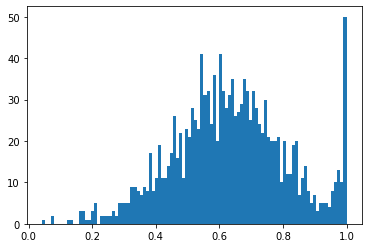

In [145]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [146]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [147]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [148]:
top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

64

<b>Helper functions</b>

These are the helper functions for evaluating the seq2seq model's performance. Basically, the function get_all_sentences() returns the source text sequence, the target entity sequence and the predicted entity sequence that generated by our trained model.

In [149]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'])
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

<b>Disagreements</b>

The following codes are used to calculate the percentage of disagreements for 50 sentence sequences that are picked from test dataset. 

1. We make a list called "index" with length of batch size (64), and shuffle the list so that we can randomly pick up 50 instances from our test batch called "batch_dict1" that is assigned above
2. Save all the related results (source, target, predic) to a list called "fresults"
3. Function get_result() is used to get the correct predicted entities and incorrect predicted entities for each instance
3. Function test_acc() is used to calculate the average accuracy of disagreements over 50 instances

In [11]:
#Shuffle the index so that we can randomly pick up 50 test data
import random
index = [i for i in range(args.batch_size)]
random.shuffle(index)

In [151]:
#Generate 50 cases with source text, target entities and predicted entities
fresults = [get_all_sentences(vectorizer, batch_dict1, i) for i in index[:50]]

Due to each sentence contains a lot of entities with "o", which may not be a good way to evaluate the robustness of the model. So, we add a bool argument called "rv" in the funtion get_result() and test_acc() to determine if we want to compute the accuracy with 'o' or not

In [7]:
def get_result(index, rv = False): 
    
    """
    rv determins if we want to calulate the accuracy without entities'o'
    correct: Save the correct predicted entities
    false: Save the incorrect predicted entities
    """
    correct = []          
    false = []
    truth = fresults[index]['truth'].split()
    sampled = fresults[index]['sampled'].split()
    source = fresults[index]['source'].split()
    
    if len(truth) != len(source):
        print("seq lenth error with truth length {} and source length {}!".format(len(truth), len(source)))
        return
    
    if rv:
        truth = [result for result in truth if result != 'o']
        sampled = [result1 for result1 in sampled if result1 != 'o']

    for i in range(min(len(truth), len(sampled))):
        if truth[i] == sampled[i]:
            correct.append({"sampled": sampled[i], "truth": truth[i], "source": source[i]})
        else:
            false.append({"sampled": sampled[i], "truth": truth[i], "source": source[i]})
    return correct, false

In [8]:
def test_acc(rv = False):
    
    """
    acc: Save the percentage of disagreements over 50 test instances
    """
    acc= []
    cor = []
    fal = []
    for i in range(len(fresults)):
        correct, false = get_result(i, rv)
        if len(correct) == 0 and len(false) == 0:
            continue
        cor.append(correct)
        fal.append(false)
        acc.append(len(correct)/(len(correct) + len(false)))
    return np.average(np.array(acc)), cor, fal

In [154]:
#Evaluate the disagreements on 50 test instances
test_acc()[0]

0.9198712476938635

In [155]:
#Evaluate the disagreements on 50 test instances without 'o'
test_acc(rv = True)[0]

0.6992248062015504

<b>Disagreements report</b>


From the test result on 50 instances, the percentage of disagreements is around 8%, which means our seq2seq model has about 92% accuracy, shows outstanding performance for prediction. However, the percentage of disagreements is dropped around 30% if we evaluate without using entity 'o', which means the model has about 70% to predict the correct result for the entities except 'o'. Due to the our sequence dataset includes 90% of 'o' (we proved in data pre-process step), 70% accuracy is a decent result.

<b>

<b>Improvements and Future works</b>

In this task, we use the bi-GRU as encoder, GRU as decoder and combine attention to train the seq2seq model. This models obtain a decent result on the test dataset. However, RNN related modes (RNN, GRU, LSTM) still facing the problem of short memory despite the significant improvment of using bidirectional strategy. Hence, the transformer method is proposed by Vaswani A and Shazeer N (2017) to address this problem. Transformer applys only the attention and access the token position using positional encoding. Positional encoding allows the model to catch up earlier text feature, thus improve the model accuracy when dealing with a long sequence. Moreover, this training datset includes 90% entity 'o'. In order to tackle this unbalance dataset, we can apply the Data Augmentatio technology. For example, in the paper "Learning data manipulation for augmentation and weighting". Hu Z and Tan B (2019) introduce how to reweight the data example so that the model can learn less from the simple data such as 'o' in this case, and learn more from the other hard data. Applying the Data Augmentatio technology with Transformer could be a better way to improve the model performance.